In [33]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt # for hist()
from math import sqrt
from scipy.linalg import cho_factor, cho_solve
from plotnine import *

## Read in Data

**NOTE:** for now, I'm just going to use the continuous variables that describe the song (`bpm` to `spch` columns) as explanatory/predictor variables and `pop` as the response variable

In [2]:
data = pd.read_csv("./data/SpotifyData.csv")
df = pd.DataFrame(data)
A = df.iloc[:-3, 5:15] # last 3 rows are all NAs; want bpm to pop columns
A.head(10)

,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0
1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0
2,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0
3,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0
4,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0
5,82.0,93.0,55.0,-4.0,35.0,79.0,196.0,1.0,34.0,71.0
6,128.0,81.0,82.0,-8.0,60.0,44.0,308.0,7.0,7.0,75.0
7,92.0,52.0,60.0,-7.0,31.0,41.0,258.0,18.0,37.0,71.0
8,146.0,59.0,50.0,-5.0,11.0,8.0,218.0,51.0,3.0,87.0
9,109.0,84.0,64.0,-5.0,6.0,42.0,221.0,1.0,4.0,86.0


## Finding Regression Coefficients and their Standard Errors

### LU Decomposition

In [3]:
X = np.array(A.drop(columns=["pop"])) # all columns but pop
y = np.array(A["pop"]) # pop is response var

XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

B_lu = np.linalg.solve(XtX, Xty)
B_lu

array([ 0.08241961,  0.2386197 ,  0.28474722, -2.05055135, -0.0174965 ,
        0.02652841,  0.06685668,  0.1151192 , -0.01879867])

For the standard errors, we will first find an estimate of the variance using the formula $\hat{\sigma}^2 = (Y - X\hat{\beta})'(Y - X\hat{\beta})/(n-p)$:

In [4]:
S = y - X.dot(B_lu)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

sigma2_hat = np.matrix.transpose(S).dot(S) / (n-p)
sigma2_hat

103.03890911525502

Next we implement the formula $SE[\hat{\beta}] = \sqrt{\sigma^2 diag((X^TX)^{-1})}$ using `np.linalg.solve()` to find the inverse of $X^TX$:

In [5]:
a = sigma2_hat * np.diag(np.linalg.inv(XtX))
np.sqrt(a)

array([0.01172805, 0.02408706, 0.02283366, 0.19040556, 0.02441092,
       0.0173109 , 0.00742862, 0.01860036, 0.03621751])

### Cholesky Decomposition

In [6]:
# using cho_factor() to obtain the lower-triangular Cholesky decomposition for X'X; equates to LL'
L, Lt = cho_factor(XtX, lower = True)

B_chol = cho_solve((L, Lt), Xty)
B_chol

array([ 0.08241961,  0.2386197 ,  0.28474722, -2.05055135, -0.0174965 ,
        0.02652841,  0.06685668,  0.1151192 , -0.01879867])

We will then find the estimate of the variance for the standard errors. 

In [7]:
aug_mat = np.array(A)
AtA = np.matrix.transpose(aug_mat).dot(aug_mat) # to ensure square matrix

L, Lt = cho_factor(AtA, lower = True)

d = L[L.shape[0]-1, L.shape[1]-1] # d is bottom right element of the lower triangular matrix

n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X

sigma2_hat = d**2/(n - p)
sigma2_hat

103.03890911525508

In [8]:
L = np.linalg.cholesky(XtX)
a = sigma2_hat * np.diag(scipy.linalg.inv(L @ L.transpose()))
np.sqrt(a)

array([0.01172805, 0.02408706, 0.02283366, 0.19040556, 0.02441092,
       0.0173109 , 0.00742862, 0.01860036, 0.03621751])

## Simulation Study

In [9]:
#num of observations
n = 16
# num of features
p = 7
# determine the design matrix
seed = 108

X = np.array(np.random.normal(0, 1, n*p))
X = X.reshape(n,p)

beta = np.repeat(3, p)
sigma = 1

y = X.dot(beta) + np.random.normal(0, sigma, n)

In [10]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

beta_est = np.linalg.solve(XtX, Xty)

S = y - X.dot(beta_est)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

sigma_est = np.matrix.transpose(S).dot(S) / (n-p)

beta_est

array([3.26672246, 2.64316466, 3.21759241, 2.87422989, 2.98453243,
       3.01742086, 2.62168713])

In [11]:
sigma_est

1.9657810738125236

In [12]:
pd.DataFrame(data={"True Beta": beta, "Beta Est": beta_est})

,True Beta,Beta Est
0,3,3.266722
1,3,2.643165
2,3,3.217592
3,3,2.874230
4,3,2.984532
5,3,3.017421
6,3,2.621687


In [13]:
print("True Sigma: " + str(sigma) + "\nEst sigma: "+str(sigma_est))

True Sigma: 1
Est sigma: 1.9657810738125236


In [14]:
num_datasets = 100
y_bar = X.dot(beta)
Y = [y_bar+np.random.normal(0, sigma, n) for i in range(num_datasets)]
Y = np.concatenate(Y, axis=0 )
Y = Y.reshape(16, 100)

In [15]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(Y)
Beta =  np.linalg.solve(XtX, Xty)

S = Y - X.dot(Beta)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X
Sigma = np.matrix.transpose(S).dot(S) / (n-p)

In [30]:
beta_df = pd.DataFrame(Beta)
beta_df2 = pd.melt(beta_df.reset_index(), id_vars="index")
beta_df2.head
# source: https://stackoverflow.com/questions/50529022/pandas-melt-unmelt-preserve-index

<bound method NDFrame.head of      index variable     value
0        0        0  0.334653
1        1        0 -3.155766
2        2        0 -1.679101
3        3        0  3.781532
4        4        0  1.397662
..     ...      ...       ...
695      2       99  5.272596
696      3       99 -2.457988
697      4       99  1.132264
698      5       99  2.956720
699      6       99  1.868152

[700 rows x 3 columns]>

In [45]:
ggplot() + geom_histogram(aes(x="Sigma"), bins = 10) 

PlotnineError: "The 'x' mapping: 'Sigma' produced a value of type '<class 'numpy.ndarray'>',but only single items and lists/arrays can be used. (original error: Cannot set a frame with no defined index and a value that cannot be converted to a Series)"

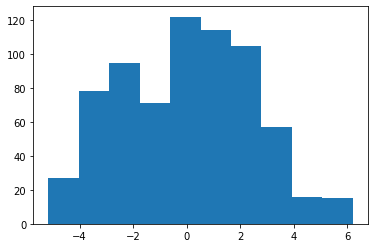

In [21]:
plt.hist(beta_df2["value"])
plt.show()  